# Import Libraries

In [2]:
import os
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [3]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

# Setup the environment

In [4]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
sample_dir = workdir / "data" / "tiled" / "proc2048_nc1024_size625_nsteps60_s401_10tiled"
info = InfoExtractor.extract_info_from_path(sample_dir)

sample_tiled_dir = workdir / "data" / "tiled" / "proc2048_nc1024_size625_nsteps60_s401_10tiled"
sample_bigbox_dir = workdir / "data" / "bigbox" / "rfof_proc131072_nc6144_size3750_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s110_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8"
info_tiled = InfoExtractor.extract_info_from_path(sample_tiled_dir)
info_bigbox = InfoExtractor.extract_info_from_path(sample_bigbox_dir)

zs = 2.0

In [5]:
config = load_config(config_file)
setup_logging()

In [5]:
filtered_config_pp = filter_config(config, PatchProcessor)
pp = PatchProcessor(**filtered_config_pp)

filtered_config_pa = filter_config(config, PatchAnalyser)
pa = PatchAnalyser(pp, **filtered_config_pa)

filtered_config_fsa = filter_config(config, FullSkyAnalyser)
fsa = FullSkyAnalyser(**filtered_config_fsa)

ka = KappaAnalyser(sample_dir, pa, fsa)

In [31]:
# ka.analyse()

# Sample run

In [6]:
sample_patch_tiled_path = list((workdir / "data" / "patches"/ "tiled"/ f"zs{zs}").glob(f"*.npy"))[0]
sample_patch_bigbox_path = list((workdir / "data" / "patches"/ "bigbox"/ f"zs{zs}").glob(f"*.npy"))[0]

In [7]:
sample_patch_tiled = np.load(sample_patch_tiled_path)
sample_patch_bigbox = np.load(sample_patch_bigbox_path)

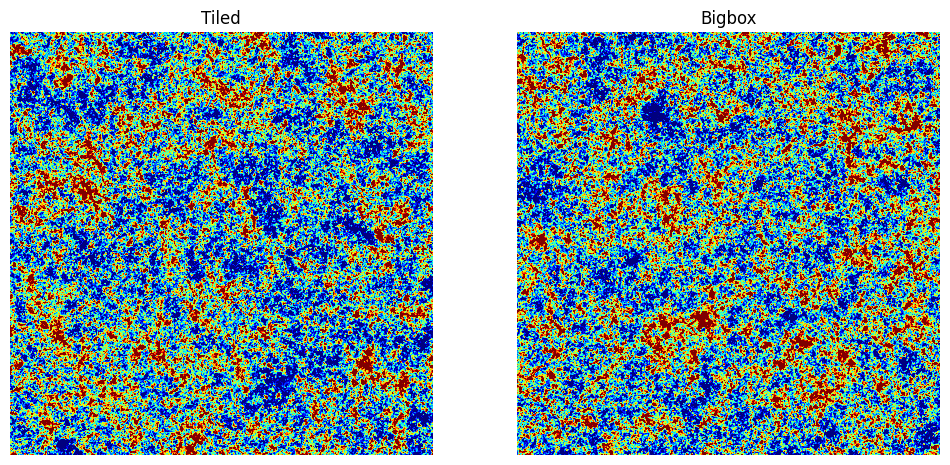

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sample_patch_tiled[0], cmap="jet", vmin=-0.032, vmax=0.032)
ax[0].set_title("Tiled")

ax[1].imshow(sample_patch_bigbox[0], cmap="jet", vmin=-0.032, vmax=0.032)
ax[1].set_title("Bigbox")

for a in ax:
    a.axis("off")

plt.show()

In [36]:
def load_results_from_hdf5(hdf5_path):
    """
    Loads the results from an HDF5 file into a nested dictionary.
    
    Parameters:
    - hdf5_path (str or Path): Path to the HDF5 file.
    
    Returns:
    - results (dict): Nested dictionary mirroring the original structure.
    """
    results = {}
    with h5py.File(hdf5_path, 'r') as hf:
        for ngal_key in hf.keys():
            # Extract 'ngal' value from group name
            ngal = float(ngal_key.replace('ngal_', ''))
            results[ngal] = {}
            ngal_group = hf[ngal_key]
            
            # Load 'cl', 'equilateral', 'isosceles', 'squeezed'
            for key in ['cl', 'equilateral', 'isosceles', 'squeezed']:
                if key in ngal_group:
                    results[ngal][key] = np.array(ngal_group[key])
            
            # Iterate over 'sl' groups
            for sl_key in ngal_group.keys():
                if sl_key.startswith('sl_'):
                    sl = float(sl_key.replace('sl_', ''))
                    results[ngal][sl] = {}
                    sl_group = ngal_group[sl_key]
                    
                    for sub_key in ['pdf', 'peaks', 'minima', 'v0', 'v1', 'v2', 'sigma0', 'sigma1']:
                        if sub_key in sl_group:
                            results[ngal][sl][sub_key] = np.array(sl_group[sub_key])
    return results

In [37]:
load_results_from_hdf5(hdf5_path)

{0.0: {'cl': array([[6.94567370e-06, 7.78967842e-06, 8.36708477e-06, ...,
          1.89670318e-05, 1.77992315e-05, 1.70566382e-05],
         [6.58907720e-06, 9.32821604e-06, 9.97871211e-06, ...,
          2.20305574e-05, 2.13555650e-05, 2.10656781e-05],
         [8.46966122e-06, 9.33657611e-06, 1.29671735e-05, ...,
          2.32292896e-05, 2.14217671e-05, 2.06523873e-05],
         ...,
         [9.23857533e-06, 1.03158636e-05, 1.12549860e-05, ...,
          1.91257950e-05, 1.83562406e-05, 1.75278037e-05],
         [6.86225485e-06, 8.12557846e-06, 9.56881922e-06, ...,
          2.08199162e-05, 1.91086492e-05, 1.85130211e-05],
         [8.58654039e-06, 7.72126259e-06, 8.48933905e-06, ...,
          2.09398459e-05, 1.96322944e-05, 1.87510595e-05]], dtype=float32),
  'equilateral': array([[4.0992610e-08, 5.2610851e-08, 1.5418689e-08, ..., 3.5078190e-07,
          4.5859576e-07, 9.6742262e-08],
         [6.1472981e-08, 5.0805909e-08, 1.4273630e-07, ..., 3.1999994e-07,
          1.3801356e

In [35]:
import h5py
import numpy as np

hdf5_path =  "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/tiled/stats/stats_zs0.5_s100_oa10.h5"
with h5py.File(hdf5_path, 'r') as hf:
    print(hf.keys())
    print(hf['ngal_15'].keys())
    print(hf['ngal_15']['sl_5'].keys())

    # Select a specific 'ngal' group
    ngal_group = hf['ngal_15']
    
    # Access 'cl' dataset
    cl_data = ngal_group['cl'][:]
    print("cl_data shape:", cl_data.shape)
    print("cl_data:", cl_data)
    
    # Access 'equilateral' dataset
    equilateral_data = ngal_group['equilateral'][:]
    
    # Access a specific 'sl' group, e.g., 'sl_5'
    sl_group = ngal_group['sl_5']
    
    # Access 'pdf' dataset within 'sl_5'
    pdf_data = sl_group['pdf'][:]
    print("pdf_data shape:", pdf_data.shape)
    print("pdf_data:", pdf_data)


<KeysViewHDF5 ['ngal_0', 'ngal_15', 'ngal_30', 'ngal_50', 'ngal_7']>
<KeysViewHDF5 ['cl', 'equilateral', 'isosceles', 'sl_10', 'sl_2', 'sl_5', 'sl_8', 'squeezed']>
<KeysViewHDF5 ['minima', 'pdf', 'peaks', 'v0', 'v1', 'v2']>
cl_data shape: (265, 15)
cl_data: [[1.53061610e-05 1.66196351e-05 2.25097883e-05 ... 2.81511428e-04
  3.65644199e-04 5.04591851e-04]
 [1.23921545e-05 1.83982447e-05 2.27758283e-05 ... 2.70774122e-04
  3.65439599e-04 4.87771846e-04]
 [1.57759750e-05 2.16245317e-05 2.57946813e-05 ... 2.83115165e-04
  3.69101996e-04 5.03291783e-04]
 ...
 [1.24206008e-05 2.12203395e-05 2.43211889e-05 ... 2.74793420e-04
  3.85708438e-04 4.80787043e-04]
 [1.15268467e-05 1.48509234e-05 1.77865695e-05 ... 2.80973880e-04
  3.71212576e-04 4.80911229e-04]
 [1.34917391e-05 1.73064418e-05 2.08996607e-05 ... 2.79482512e-04
  3.83168168e-04 4.83196432e-04]]
pdf_data shape: (265, 15)
pdf_data: [[2.81175860e-04 6.71772636e-04 4.17727791e-03 ... 1.79176740e-02
  8.71241558e-03 5.26341517e-03]
 [0.000

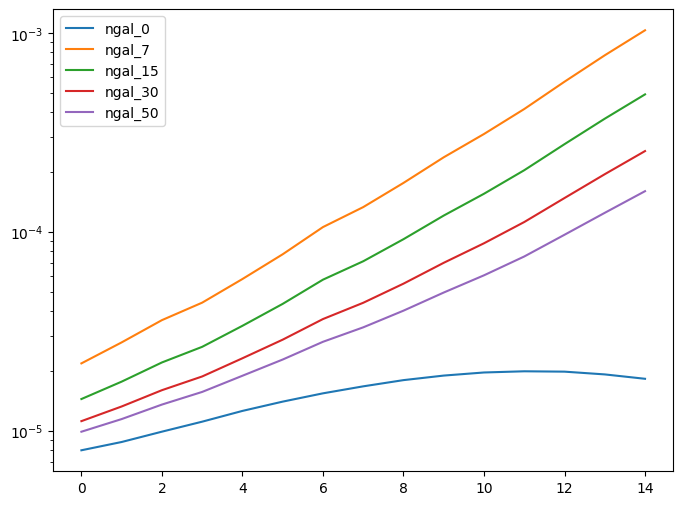

In [32]:
# plot the power spectrum
plt.figure(figsize=(8, 6))
with h5py.File(hdf5_path, 'r') as hf:
    plt.plot(np.mean(hf['ngal_0']['cl'][:], axis=0), label="ngal_0")
    plt.plot(np.mean(hf['ngal_7']['cl'][:], axis=0), label="ngal_7")
    plt.plot(np.mean(hf['ngal_15']['cl'][:], axis=0), label="ngal_15")
    plt.plot(np.mean(hf['ngal_30']['cl'][:], axis=0), label="ngal_30")
    plt.plot(np.mean(hf['ngal_50']['cl'][:], axis=0), label="ngal_50")
plt.yscale("log")
plt.legend()
plt.show()

In [50]:
patch_kappa_path = ka.patch_kappa_paths[0]
tmp_kappa_patches = np.load(patch_kappa_path)
tmp_snr_paths = ka._filter_paths_by_input(ka.patch_snr_paths, patch_kappa_path)
patch_snr_path = tmp_snr_paths[0]
fname = Path(patch_snr_path).name.replace('patches', 'analysis')
snr_patches = np.load(patch_snr_path)
data = ka.pa.process_patches(tmp_kappa_patches, snr_patches)

KeyboardInterrupt: 

In [ ]:
# sk0, sk1, sk2, kur0, kur1, kur2, kur3 are scalars
# all the other values are the same length: pa.nbin
# The order of the values is equilateral, isosceles, squeezed, clkk,
#            sk0, sk1, sk2, kur0, kur1, kur2, kur3,
#            pdf_vals, peaks, minima, v0, v1, v2

# separate the data
equilateral = data[:, pa.nbin * 0:pa.nbin * 1]
isosceles = data[:, pa.nbin * 1:pa.nbin * 2]
squeezed = data[:, pa.nbin * 2:pa.nbin * 3]
clkk = data[:, pa.nbin * 3:pa.nbin * 4]
sk0 = data[:, pa.nbin * 4]
sk1 = data[:, pa.nbin * 4 + 1]
sk2 = data[:, pa.nbin * 4 + 2]
kur0 = data[:, pa.nbin * 4 + 3]
kur1 = data[:, pa.nbin * 4 + 4]
kur2 = data[:, pa.nbin * 4 + 5]
kur3 = data[:, pa.nbin * 4 + 6]
pdf_vals = data[:, pa.nbin * 4 + 7:pa.nbin * 5 + 7]
peaks = data[:, pa.nbin * 5 + 7:pa.nbin * 6 + 7]
minima = data[:, pa.nbin * 6 + 7:pa.nbin * 7 + 7]
v0 = data[:, pa.nbin * 7 + 7:pa.nbin * 8 + 7]
v1 = data[:, pa.nbin * 8 + 7:pa.nbin * 9 + 7]
v2 = data[:, pa.nbin * 9 + 7:pa.nbin * 10 + 7]

In [ ]:
global_std = np.std(snr_patches)

In [ ]:
from lenstools import ConvergenceMap
from astropy import units as u

patch_pixels = tmp_kappa_patches[0]
patch_snr_pixels = snr_patches[0]

# Process kappa (convergence) map
conv_map = ConvergenceMap(patch_pixels, angle=pa.patch_size * u.deg)
equilateral, isosceles, squeezed = pa._compute_bispectrum(conv_map)
clkk = pa._compute_power_spectrum(conv_map)
sk0, sk1, sk2, kur0, kur1, kur2, kur3 = pa._compute_moments(conv_map, global_std)

# Process SNR map
snr_map = ConvergenceMap(patch_snr_pixels/global_std, angle=pa.patch_size * u.deg)
pdf_vals = pa._compute_pdf(snr_map)
peaks = pa._compute_peak_statistics(snr_map, is_minima=False)
minima = pa._compute_peak_statistics(snr_map, is_minima=True)
v0,v1,v2 = pa._compute_minkowski_functionals(snr_map)

# Check the output files

### indivisual run

In [6]:
zs = 2.0
sample_tiled_path = list((sample_tiled_dir / "analysis_patch" ).glob(f"analysis_zs{zs}_s{info_tiled['seed']}_oa10_noiseless_sl2.npy"))[0]
sample_bigbox_path = list((sample_bigbox_dir / "analysis_patch" ).glob(f"analysis_zs{zs}_s{info_bigbox['seed']}_oa10_noiseless_sl2.npy"))[0]

In [7]:
data_tiled = np.load(sample_tiled_path)
data_bigbox = np.load(sample_bigbox_path)

In [8]:
nbin=15
lmin = 300
lmax = 3000
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1, endpoint=True)
ell = (l_edges[1:] + l_edges[:-1]) / 2

In [38]:
bad_patches = {}
fine_patches = {}
for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    bad_patches[zs] = []
    fine_patches[zs] = []

    sample_tiled_paths = list((workdir / "data" / "tiled"  ).glob(f"*/analysis_patch/analysis_zs{zs}_s*_oa10_noiseless_sl2.npy"))

    for sample_tiled_path in sample_tiled_paths:
        data_tiled = np.load(sample_tiled_path)

        bad_patches[zs].append(data_tiled[132, :nbin])

        # delete the bad index 132
        data_tiled = np.delete(data_tiled, 132, axis=0)
        fine_patches[zs].append(data_tiled[:, :nbin])

    bad_patches[zs] = np.array(bad_patches[zs])
    fine_patches[zs] = np.vstack(np.array(fine_patches[zs]))

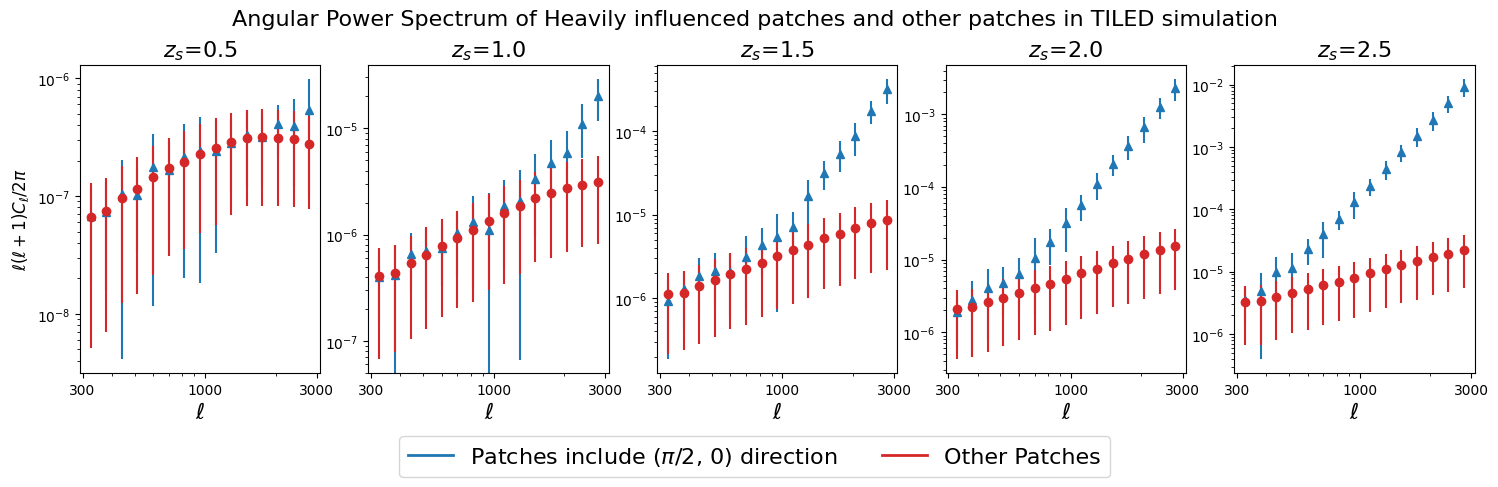

In [45]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 5, figsize=(18, 4))

for i, zs in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    ax[i].errorbar(ell, np.mean(bad_patches[zs], axis=0), yerr =np.std(bad_patches[zs], axis=0), color="tab:blue", fmt="^")
    ax[i].errorbar(ell, np.mean(fine_patches[zs], axis=0), yerr = np.std(fine_patches[zs], axis=0), color="tab:red", fmt="o")

    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_title(f"$z_s$={zs}", fontsize=16)
    ax[i].set_xlabel(r"$\ell$", fontsize=16)

    if i == 0:
        ax[i].set_ylabel(r"$\ell(\ell + 1) C_\ell / 2\pi$", fontsize=12)
    #else:
    #    ax[i].set_yticklabels([])

    ax[i].set_xticks([300, 1000, 3000])
    ax[i].set_xticklabels(["300", "1000", "3000"])

custom_lines = [Line2D([0], [0], color="tab:blue", lw=2), Line2D([0], [0], color="tab:red", lw=2)]
fig.legend(custom_lines, [r"Patches include ($\pi/2$, 0) direction", "Other Patches"], bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=2, fontsize=16)

fig.suptitle(r"Angular Power Spectrum of Heavily influenced patches and other patches in TILED simulation", fontsize=16, y=1.02)

fig.savefig("/lustre/work/akira.tokiwa/Projects/LensingSSC/plot/final/patch_replication_heavily.png", bbox_inches="tight")

In [8]:
means_tiled = np.mean(data_tiled, axis=0)
corr_tiled = np.corrcoef(data_tiled, rowvar=False)

means_bigbox = np.mean(data_bigbox, axis=0)
corr_bigbox = np.corrcoef(data_bigbox, rowvar=False)

/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/akira.tokiwa/.conda/envs/lssc/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [12]:
means_tiled.shape

(157,)

### batch run

In [9]:
sample_bigbox_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/patch_stats_bigbox_oa10_noiseless_sl2.npy"
sample_tiled_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/patch_stats_tiled_oa10_noiseless_sl2.npy"

sample_bigbox_rand_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/bigbox_rand/output/patch_stats_bigbox_oa10_noiseless_sl2.npy"
sample_tiled_rand_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/tiled_rand/output/patch_stats_tiled_oa10_noiseless_sl2.npy"

In [10]:
data_tiled = np.load(sample_tiled_path, allow_pickle=True).item()
data_bigbox = np.load(sample_bigbox_path, allow_pickle=True).item()

data_tiled_rand = np.load(sample_tiled_rand_path, allow_pickle=True).item()
data_bigbox_rand = np.load(sample_bigbox_rand_path, allow_pickle=True).item()

FileNotFoundError: [Errno 2] No such file or directory: '/lustre/work/akira.tokiwa/Projects/LensingSSC/output/patch_stats_tiled_oa10_noiseless_sl2.npy'

In [9]:
def merge_corr(corr1, corr2):
    if corr1.shape != corr2.shape or corr1.ndim != 2 or corr1.shape[0] != corr1.shape[1]:
        raise ValueError("Both correlation matrices must be square and have the same shape.")
    
    merged_corr = np.zeros_like(corr1)
    upper_indices = np.triu_indices_from(corr1, k=1)
    lower_indices = np.tril_indices_from(corr1, k=-1)
    
    merged_corr[upper_indices] = corr1[upper_indices]
    merged_corr[lower_indices] = corr2[lower_indices]
    np.fill_diagonal(merged_corr, 1.0)
    
    return merged_corr

### Comparison with halofit

In [10]:
halofit_dir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC/data/halofit")
halofit_paths = sorted(list(halofit_dir.glob("*.npz")))

In [11]:
def discretize_cl(cl_cont,lmin=300, lmax=3000, nbin=15):
        l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1)
        ell = np.arange(2, lmax + 1)
        bin_indices = np.digitize(ell, l_edges, right=True)

        # Exclude out-of-range indices
        valid = (bin_indices > 0) & (bin_indices <= nbin)
        bin_indices = bin_indices[valid]
        cl_values = cl_cont # Assuming cl_cont starts at ell=0

        cl_sum = np.bincount(bin_indices, weights=cl_values[valid], minlength=nbin + 1)
        counts = np.bincount(bin_indices, minlength=nbin + 1)

        with np.errstate(divide='ignore', invalid='ignore'):
            cl_disc = np.divide(cl_sum, counts, where=counts > 0)[1:nbin + 1]

        return cl_disc

In [12]:
# Fullsky area in square degrees 
fs_area = 4 * np.pi * (180 / np.pi) ** 2
f_sky = 100 / fs_area

In [13]:
lmin, lmax, nbin = config["lmin"], config["lmax"], config["nbin"]
l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1)
ell = (l_edges[1:] + l_edges[:-1]) / 2
nmodes = np.diff(np.log(l_edges))
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
colors = {zs: color for zs, color in zip(zs_list, ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])}
save_dir="/lustre/work/akira.tokiwa/Projects/LensingSSC/plot"

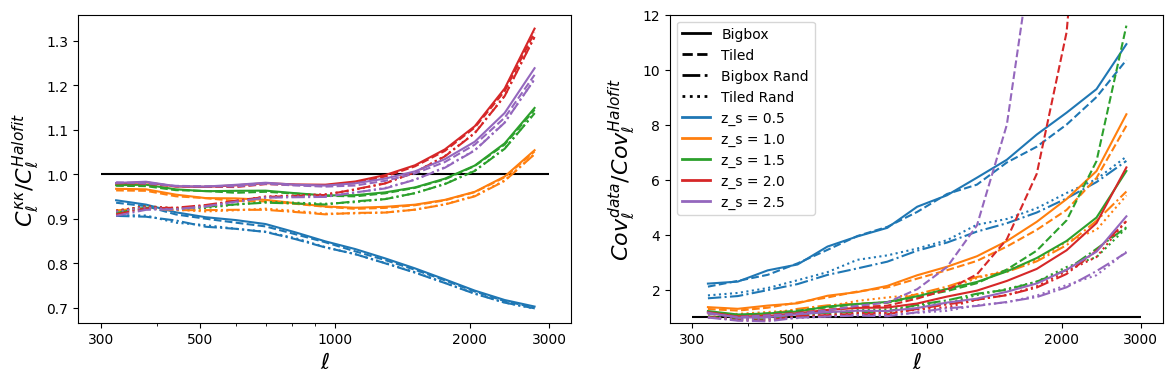

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].hlines(1, lmin, lmax, color="black")
ax[1].hlines(1, lmin, lmax, color="black")

for halofit_path in halofit_paths[:-1]:
    data_hf = np.load(halofit_path)
    zs = InfoExtractor.extract_redshift_from_path(str(halofit_path))
    ell_cont = data_hf["ell"]
    clkk = data_hf["clkk"]* ell_cont * (ell_cont + 1) / (2 * np.pi)
    clkk = discretize_cl(clkk) 
    ax[0].plot(ell,data_tiled[zs]["means"][45:60] /clkk , label=f"zs={zs}", color=colors[zs])
    ax[0].plot(ell,data_bigbox[zs]["means"][45:60] /clkk , color=colors[zs], linestyle="--")
    ax[0].plot(ell,data_tiled_rand[zs]["means"][45:60] / clkk, color=colors[zs], linestyle="-.")
    ax[0].plot(ell,data_bigbox_rand[zs]["means"][45:60] / clkk, color=colors[zs], linestyle=":")

    ax[1].plot(ell,data_tiled[zs]["diags"][45:60] /(clkk**2 / (f_sky * nmodes * ell**2)) , linestyle="--", color=colors[zs])
    ax[1].plot(ell,data_bigbox[zs]["diags"][45:60] /(clkk**2 / (f_sky * nmodes * ell**2)) , color=colors[zs])
    ax[1].plot(ell,data_tiled_rand[zs]["diags"][45:60] /(clkk**2 / (f_sky * nmodes * ell**2)) , linestyle="-.", color=colors[zs])
    ax[1].plot(ell,data_bigbox_rand[zs]["diags"][45:60] /(clkk**2 / (f_sky * nmodes * ell**2)) , linestyle=":", color=colors[zs])

redshift_handles = [
    Line2D([0], [0], color=colors[zs], lw=2, label=r"z_s = " + f'{zs}') 
    for zs in zs_list
]

# Create custom legend handles for box types (linestyles)
boxtype_handles = [
    Line2D([0], [0], color='black', lw=2, linestyle=linestyle, label=box_type) 
    for linestyle, box_type in zip(['-', '--', '-.', ':'], ['Bigbox', 'Tiled', 'Bigbox Rand', 'Tiled Rand'])
]

ax[1].legend(handles= boxtype_handles + redshift_handles, loc="upper left", fontsize=10)
ax[0].set_xscale("log")
ax[0].set_xlabel(r"$\ell$", fontsize=16)
ax[0].set_xticks([300, 500, 1000, 2000, 3000])
ax[0].set_xticklabels([300, 500, 1000, 2000, 3000])
ax[0].set_ylabel(r"$C_{\ell}^{\kappa\kappa} / C_{\ell}^{Halofit}$", fontsize=16)

ax[1].set_xscale("log")
ax[1].set_xlabel(r"$\ell$", fontsize=16)
ax[1].set_xticks([300, 500, 1000, 2000, 3000])
ax[1].set_xticklabels([300, 500, 1000, 2000, 3000])
ax[1].set_ylim(0.8, 12)
ax[1].set_ylabel(r"$Cov_{\ell}^{data} / Cov_{\ell}^{Halofit}$", fontsize=16)

fig.savefig(os.path.join(save_dir, "comparison_halofit_final.png"), bbox_inches='tight')

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

class FinalPlotter:
    def __init__(self, 
                 sl_main = 2,
                 ngal_main = 0,
                 sl_list = [2, 5, 8, 10],
                 ngal_list = [0, 50, 30, 15, 7], 
                 data_dir="/lustre/work/akira.tokiwa/Projects/LensingSSC/output/prev", 
                 oa=10, 
                 zs_list=[0.5, 1.0, 1.5, 2.0, 2.5], 
                 lmin=300, lmax=3000, nbin = 15, 
                 maincmap="viridis", subcmap='plasma',
                 save_dir="/lustre/work/akira.tokiwa/Projects/LensingSSC/plot/prev"):
        self.data_dir = data_dir
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.sl_main = sl_main
        self.ngal_main = ngal_main
        self.sl_list = sl_list
        self.ngal_list = ngal_list
        self.oa = oa
        self.zs_list = zs_list
        self.colors = {zs: color for zs, color in zip(zs_list, ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])}
        self.labels = [
            r"$C^{\kappa\kappa}_{\ell}$",
            r'$B_{\ell}^\mathrm{sq}$',  
            r'$B_{\ell}^\mathrm{iso}$',
            r'$B_{\ell}^\mathrm{eq}$', 
            "PDF",
            "Peak",
            "Min",
            r"$Area_\mathrm{MF}$",
            r"$Perim_\mathrm{MF}$",
            r"$Genus_\mathrm{MF}$",
        ]

        self.stats_name_indices = {
            'angular power spectrum': [45, 60],
            'squeezed bispectrum': [30, 45],
            'isosceles bispectrum': [15, 30],
            'equilateral bispectrum': [0, 15],
            'PDF': [60, 75],
            'Peak': [75, 90],
            'Minima': [90, 105],
            'area(MFs)': [105, 120],
            'perimeter(MFs)': [120, 135],
            'genus(MFs)': [135, 150],
        }

        self.stats_desired_order = [
            'angular power spectrum',
            'squeezed bispectrum',
            'isosceles bispectrum',
            'equilateral bispectrum',
            'PDF',
            'Peak',
            'Minima',
            'area(MFs)',
            'perimeter(MFs)',
            'genus(MFs)'
        ]
        self.permuted_indices = self.prepare_permuted_indices()
        self.permuted_stats_name_indices = self.construct_new_stats_name_indices()

        self.nbin = nbin
        self.l_edges = np.logspace(np.log10(lmin), np.log10(lmax), nbin + 1, endpoint=True)
        self.bins = np.linspace(-4, 4, nbin + 1, endpoint=True)

        self.ell = (self.l_edges[1:] + self.l_edges[:-1]) / 2
        self.nu = (self.bins[1:] + self.bins[:-1]) / 2

        self.maincmap = maincmap
        self.subcmap = subcmap

    def prepare_permuted_indices(self):
        permuted_indices = []
        for stat in self.stats_desired_order:
            if stat not in self.stats_name_indices:
                raise ValueError(f"Statistic '{stat}' not found in stats_name_indices mapping.")
            
            start, end = self.stats_name_indices[stat]
            stat_indices = list(range(start, end))
            permuted_indices.extend(stat_indices)
        
        return permuted_indices
    
    def construct_new_stats_name_indices(self):
        new_stats_name_indices = {}
        current_start = 0
        for stat in self.stats_desired_order:
            original_start, original_end = self.stats_name_indices[stat]
            num_indices = original_end - original_start
            new_stats_name_indices[stat] = [current_start, current_start + num_indices]
            current_start += num_indices
        return new_stats_name_indices

    def plot(self):
        self.plot_mean()
        self.plot_diag()
        self.plot_corr_noiseless()
        self.plot_corr_ngal()
        self.plot_cov_ngal()

    def _prepare_fig(self):
        fig = plt.figure(figsize=(14, 6))
        gs_master = GridSpec(nrows=2, ncols=5, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
        gs_ell = [GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_master[0, j], height_ratios=[3, 1], hspace=0.01) for j in range(5)]
        gs_nu = [GridSpecFromSubplotSpec(2, 1, subplot_spec=gs_master[1, j], height_ratios=[3, 1], hspace=0.01) for j in range(5)]

        axes_ell = [plt.subplot(gs_ell[j][0]) for j in range(4)]
        axes_nu = [plt.subplot(gs_ell[4][0])] + [plt.subplot(gs_nu[j][0]) for j in range(5)]
        axes_ratio_ell = [plt.subplot(gs_ell[j][1]) for j in range(4)]
        axes_ratio_nu = [plt.subplot(gs_ell[4][1])] + [plt.subplot(gs_nu[j][1]) for j in range(5)]

        for ax in axes_ell + axes_ratio_ell:
            ax.set_xscale('log')
            ax.set_xticks([300, 500, 1000, 2000, 3000])

        for ax in axes_nu + axes_ratio_nu:
            ax.set_xticks([-4, -2, 0, 2, 4])

        for ax in axes_ratio_ell + axes_ratio_nu:
            ax.set_ylim(0.8, 1.2)

        for ax in axes_ell + axes_nu:
            ax.set_yscale('log')
            ax.set_xticklabels([])
        
        for ax in axes_ratio_nu:
            ax.hlines(1, -4, 4, color='k', linestyle='--')
            ax.set_xticklabels([-4, -2, 0, 2, 4])
            
        for ax in axes_ratio_ell:
            ax.hlines(1, 300, 3000, color='k', linestyle='--')
            ax.set_xticklabels([300, 500, 1000, 2000, 3000])    

        # tick label font size
        for ax in axes_ell + axes_nu + axes_ratio_ell + axes_ratio_nu:
            ax.tick_params(axis='both', which='major', labelsize=8)

        ax = [axes_ell, axes_nu, axes_ratio_ell, axes_ratio_nu]

        return fig, ax
    
    def _load_stats(self, sl, ngal, box_type='tiled'):
        suffix = self._generate_suffix(sl, ngal)
        fname = f"patch_stats_{box_type}_{suffix}.npy"
        load_path = os.path.join(self.data_dir, box_type ,fname)
        #if box_type == 'tiled':
        #    load_path = Path(f"/lustre/work/akira.tokiwa/Projects/LensingSSC/data/{box_type}_rand/output") / fname
        #else:
        #    load_path = Path(f"/lustre/work/akira.tokiwa/Projects/LensingSSC/output") / fname
        print(f"Loading stats from {os.path.basename(load_path)}")
        return np.load(load_path, allow_pickle=True).item()
    
    def _generate_suffix(self, sl, ngal):
        suffix = f"oa{self.oa}_noiseless_sl{sl}" 
        if ngal != 0:
            suffix = suffix.replace("noiseless", f"ngal{ngal}")
        return suffix

    def plot_mean(self):
        fig, ax = self._prepare_fig()
        axes_ell, axes_nu, axes_ratio_ell, axes_ratio_nu = ax
        stats_tiled = self._load_stats(self.sl_main, self.ngal_main, box_type='tiled')
        stats_bigbox = self._load_stats(self.sl_main, self.ngal_main, box_type='bigbox')
        for zs in self.zs_list:
            means_tiled, stds_tiled = stats_tiled[zs]['means'][self.permuted_indices], stats_tiled[zs]['stds'][self.permuted_indices]
            means_bigbox, stds_bigbox = stats_bigbox[zs]['means'][self.permuted_indices], stats_bigbox[zs]['stds'][self.permuted_indices]

            for i, label in enumerate(self.stats_desired_order):
                if label in ['angular power spectrum','squeezed bispectrum','isosceles bispectrum','equilateral bispectrum']:
                    start, end = self.permuted_stats_name_indices[label]
                    axes_ell[i].errorbar(self.ell, means_bigbox[start:end], yerr=stds_bigbox[start:end], label=f"Bigbox: zs={zs}", color=self.colors[zs])
                    axes_ell[i].errorbar(self.ell, means_tiled[start:end], yerr=stds_tiled[start:end], label=f"Tiled: zs={zs}", color=self.colors[zs], linestyle='--')

                    axes_ratio_ell[i].plot(self.ell, means_bigbox[start:end] / means_tiled[start:end], color=self.colors[zs])
                    axes_ell[i].set_title(self.labels[i])                   
                elif label in ['PDF','Peak','Minima','area(MFs)','perimeter(MFs)','genus(MFs)']:
                    start, end = self.permuted_stats_name_indices[label]
                    k = i - len(self.stats_name_indices)
                    axes_nu[k].errorbar(self.nu, np.abs(means_bigbox[start:end]), yerr=stds_bigbox[start:end], label=f"Bigbox: zs={zs}", color=self.colors[zs])
                    axes_nu[k].errorbar(self.nu, np.abs(means_tiled[start:end]), yerr=stds_tiled[start:end], label=f"Tiled: zs={zs}", color=self.colors[zs], linestyle='--')

                    axes_ratio_nu[k].plot(self.nu, np.abs(means_bigbox[start:end] / means_tiled[start:end]), color=self.colors[zs])
                    axes_nu[k].set_title(self.labels[k])

        # Create custom legend handles for redshifts (colors)
        redshift_handles = [
            Line2D([0], [0], color=self.colors[zs], lw=2, label=f'zs={zs}') 
            for zs in self.zs_list
        ]

        # Create custom legend handles for box types (linestyles)
        boxtype_handles = [
            Line2D([0], [0], color='black', lw=2, linestyle=linestyle, label=box_type) 
            for linestyle, box_type in zip(['-', '--'], ['Bigbox', 'Tiled'])
        ]

        axes_nu[-1].legend(handles=redshift_handles, title='Redshift', loc='lower right', fontsize=8)
        axes_nu[0].legend(handles=boxtype_handles, title='Box Type', loc='lower right', fontsize=8)
                            
        fig.savefig(os.path.join(self.save_dir, "mean_final.png"), bbox_inches='tight')
        plt.close(fig)

    def plot_diag(self):
        fig, ax = self._prepare_fig()
        axes_ell, axes_nu, axes_ratio_ell, axes_ratio_nu = ax
        stats_tiled = self._load_stats(self.sl_main, self.ngal_main, box_type='tiled')
        stats_bigbox = self._load_stats(self.sl_main, self.ngal_main, box_type='bigbox')
        for zs in self.zs_list:
            diags_tiled = stats_tiled[zs]['diags'][self.permuted_indices]
            diags_bigbox = stats_bigbox[zs]['diags'][self.permuted_indices]

            for i, label in enumerate(self.stats_desired_order):
                if label in ['angular power spectrum','squeezed bispectrum','isosceles bispectrum','equilateral bispectrum']:
                    start, end = self.permuted_stats_name_indices[label]
                    axes_ell[i].plot(self.ell, diags_bigbox[start:end], label=f"Bigbox: zs={zs}", color=self.colors[zs])
                    axes_ell[i].plot(self.ell, diags_tiled[start:end], label=f"Tiled: zs={zs}", color=self.colors[zs], linestyle='--')

                    axes_ratio_ell[i].plot(self.ell, diags_bigbox[start:end] / diags_tiled[start:end], color=self.colors[zs])
                    axes_ell[i].set_title(self.labels[i])                   
                elif label in ['PDF','Peak','Minima','area(MFs)','perimeter(MFs)','genus(MFs)']:
                    start, end = self.permuted_stats_name_indices[label]
                    k = i - len(self.stats_name_indices)
                    axes_nu[k].plot(self.nu, diags_bigbox[start:end], label=f"Bigbox: zs={zs}", color=self.colors[zs])
                    axes_nu[k].plot(self.nu, diags_tiled[start:end], label=f"Tiled: zs={zs}", color=self.colors[zs], linestyle='--')

                    axes_ratio_nu[k].plot(self.nu, diags_bigbox[start:end] / diags_tiled[start:end], color=self.colors[zs])
                    axes_nu[k].set_title(self.labels[k])

        # Create custom legend handles for redshifts (colors)
        redshift_handles = [
            Line2D([0], [0], color=self.colors[zs], lw=2, label=f'zs={zs}') 
            for zs in self.zs_list
        ]

        # Create custom legend handles for box types (linestyles)
        boxtype_handles = [
            Line2D([0], [0], color='black', lw=2, linestyle=linestyle, label=box_type) 
            for linestyle, box_type in zip(['-', '--'], ['Bigbox', 'Tiled'])
        ]

        axes_nu[-1].legend(handles=redshift_handles, title='Redshift', loc='lower right', fontsize=8)
        axes_nu[0].legend(handles=boxtype_handles, title='Box Type', loc='lower right', fontsize=8)
                            
        fig.savefig(os.path.join(self.save_dir, "diag_final.png"), bbox_inches='tight')
        plt.close(fig)

    def plot_corr_noiseless(self):
        fig = plt.figure(figsize=(35, 14))
        gs_master = GridSpec(nrows=2, ncols=6, height_ratios=[1, 1],width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0, wspace=0.05)
        axes_merged = [plt.subplot(gs_master[0, j]) for j in range(5)]
        axes_diff = [plt.subplot(gs_master[1, j]) for j in range(5)]
        gs_cbar_merged = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[0, 5], height_ratios=[1, 8, 1])
        gs_cbar_diff = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[1, 5], height_ratios=[1, 8, 1])
        axes_cbar = [plt.subplot(gs_cbar_merged[1]), plt.subplot(gs_cbar_diff[1])]

        # Define labels and their bin spans
        labels_info = [
            (r"$C^{\kappa\kappa}_{\ell}$", 0, 15),
            (r'$B_{\ell}^\mathrm{sq}$', 15, 30),
            (r'$B_{\ell}^\mathrm{iso}$', 30, 45),
            (r'$B_{\ell}^\mathrm{eq}$', 45, 60),
            ("PDF", 60, 75),
            ("Peak", 75, 90),
            ("Min", 90, 105),
            (r"$Area_\mathrm{MF}$", 105, 120),
            (r"$Perim_\mathrm{MF}$", 120, 135),
            (r"$Genus_\mathrm{MF}$", 135, 150),
        ]

        for ax in axes_merged + axes_diff:
            ax.axis('off')

        # Customize colormaps to handle NaNs
        # For merged correlations
        maincmap = plt.get_cmap(self.maincmap).copy()
        maincmap.set_bad(color='grey')  # Set NaN regions to grey
        
        # For correlation differences
        subcmap = plt.get_cmap(self.subcmap).copy()
        subcmap.set_bad(color='grey')  # Set NaN regions to grey

        stats_tiled = self._load_stats(self.sl_main, self.ngal_main, box_type='tiled')
        stats_bigbox = self._load_stats(self.sl_main, self.ngal_main, box_type='bigbox')
        for i, zs in enumerate(self.zs_list):
            corr_tiled = stats_tiled[zs]['corr'][np.ix_(self.permuted_indices, self.permuted_indices)]
            corr_bigbox = stats_bigbox[zs]['corr'][np.ix_(self.permuted_indices, self.permuted_indices)]
            corr_merged = merge_corr(corr_bigbox, corr_tiled)
            #corr_diff = corr_bigbox - corr_tiled
            corr_ratio = corr_bigbox / corr_tiled


            cax_merged = axes_merged[i].imshow(corr_merged, cmap=maincmap, vmin=-1, vmax=1, origin='lower')
            #cax_diff = axes_diff[i].imshow(corr_diff, cmap=subcmap, vmin=-0.2, vmax=0.2, origin='lower')
            cax_ratio = axes_diff[i].imshow(corr_ratio, cmap=subcmap, vmin=0.7, vmax=1.3, origin='lower')
            axes_merged[i].set_title(r"$z_s=$"+f"{zs}", fontsize=24)

        fig.colorbar(cax_merged, cax=axes_cbar[0], orientation='vertical')
        #fig.colorbar(cax_diff, cax=axes_cbar[1], orientation='vertical')
        fig.colorbar(cax_ratio, cax=axes_cbar[1], orientation='vertical')

        # Compute centers of each label span
        centers = [ (start + end)/2 for _, start, end in labels_info ]
        labels_text = [ label for label, _, _ in labels_info ]

        # Set y-ticks and labels for axes_merged[0]
        axes_merged[0].axis('on')  # Re-enable axis
        axes_merged[0].set_yticks(centers)
        axes_merged[0].set_yticklabels(labels_text, fontsize=16)
        
        # Set y-ticks and labels for axes_diff[0]
        axes_diff[0].axis('on')  # Re-enable axis
        axes_diff[0].set_yticks(centers)
        axes_diff[0].set_yticklabels(labels_text, fontsize=16)
        
        # Set x-ticks and labels for the bottom of axes_diff
        for ax in axes_diff:
            ax.axis('on')
            ax.set_xticks(centers)
            ax.set_xticklabels(labels_text, rotation=90, fontsize=16)

        for ax in axes_merged[1:] + axes_diff[1:]:
            ax.tick_params(labelleft=False)
        for ax in axes_merged:
            ax.tick_params(labelbottom=False)

        fig.savefig(os.path.join(self.save_dir, "corr_noiseless_final.png"), bbox_inches='tight')
        plt.close(fig)

    def plot_corr_ngal(self):
        fig = plt.figure(figsize=(35, 35))
        gs_master = GridSpec(nrows=5, ncols=6, height_ratios=[1, 1,1, 1,1], width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0, wspace=0.05)
        axes_diff = np.array([[plt.subplot(gs_master[i, j]) for j in range(5)] for i in range(5)])

        survey_info = {
            '0': 'Noiseless',
            '7': 'DES',
            '15': 'HSC',
            '30': 'LSST',
            '50': 'Roman'
        }

        # Customize colormaps to handle NaNs
        # For correlation differences
        subcmap = plt.get_cmap(self.subcmap).copy()
        subcmap.set_bad(color='grey')  # Set NaN regions to grey

        for ax in axes_diff.flatten():
            ax.axis('off')

        for i, ngal in enumerate(self.ngal_list):
            stats_tiled = self._load_stats(self.sl_main, ngal, box_type='tiled')
            stats_bigbox = self._load_stats(self.sl_main, ngal, box_type='bigbox')
            for j, zs in enumerate(self.zs_list):
                corr_tiled = stats_tiled[zs]['corr'][np.ix_(self.permuted_indices, self.permuted_indices)]
                corr_bigbox = stats_bigbox[zs]['corr'][np.ix_(self.permuted_indices, self.permuted_indices)]
                #corr_diff = corr_bigbox - corr_tiled
                corr_ratio = corr_bigbox / corr_tiled

                #cax = axes_diff[i, j].imshow(corr_diff, cmap=subcmap, vmin=-0.2, vmax=0.2, origin='lower')
                cax = axes_diff[i, j].imshow(corr_ratio, cmap=subcmap, vmin=0.7, vmax=1.3, origin='lower')
                if i == 0:
                    axes_diff[i, j].set_title(r"$z_s=$"+f"{zs}", fontsize=24)
                if j == 0:
                    axes_diff[i, j].set_ylabel(f"{survey_info[str(ngal)]}", fontsize=24)
            
            gs_cbar = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[i, 5], height_ratios=[1, 8, 1])
            axes_cbar = plt.subplot(gs_cbar[1])
            fig.colorbar(cax, cax=axes_cbar, orientation='vertical')

        # Define labels and their bin spans
        labels_info = [
            (r"$C^{\kappa\kappa}_{\ell}$", 0, 15),
            (r'$B_{\ell}^\mathrm{sq}$', 15, 30),
            (r'$B_{\ell}^\mathrm{iso}$', 30, 45),
            (r'$B_{\ell}^\mathrm{eq}$', 45, 60),
            ("PDF", 60, 75),
            ("Peak", 75, 90),
            ("Min", 90, 105),
            (r"$Area_\mathrm{MF}$", 105, 120),
            (r"$Perim_\mathrm{MF}$", 120, 135),
            (r"$Genus_\mathrm{MF}$", 135, 150),
        ]

        # Compute centers of each label span
        centers = [ (start + end)/2 for _, start, end in labels_info ]
        labels_text = [ label for label, _, _ in labels_info ]
        
        # Set y-ticks and labels for axes_diff[0]
        for i in range(5):
            axes_diff[i, 0].axis('on')  # Re-enable axis
            axes_diff[i, 0].set_yticks(centers)
            axes_diff[i, 0].set_yticklabels(labels_text, fontsize=16)
            if i != 4:
                axes_diff[i, 0].tick_params(labelbottom=False)
        
        # Set x-ticks and labels for the bottom of axes_diff
        for i in range(5):
            axes_diff[4, i].axis('on')
            axes_diff[4, i].set_xticks(centers)
            axes_diff[4, i].set_xticklabels(labels_text, rotation=90, fontsize=16)
            if i != 0:
                axes_diff[4, i].tick_params(labelleft=False)

        fig.savefig(os.path.join(self.save_dir, "corr_ngal_final.png"), bbox_inches='tight')
        plt.close(fig)

    def plot_cov_noiseless(self):
        fig = plt.figure(figsize=(35, 14))
        gs_master = GridSpec(nrows=2, ncols=6, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0, wspace=0.05)
        axes_merged = [plt.subplot(gs_master[0, j]) for j in range(5)]
        axes_diff = [plt.subplot(gs_master[1, j]) for j in range(5)]
        gs_cbar_merged = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[0, 5], height_ratios=[1, 8, 1])
        gs_cbar_diff = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[1, 5], height_ratios=[1, 8, 1])
        axes_cbar = [plt.subplot(gs_cbar_merged[1]), plt.subplot(gs_cbar_diff[1])]

        # Define labels and their bin spans
        labels_info = [
            (r"$C^{\kappa\kappa}_{\ell}$", 0, 15),
            (r'$B_{\ell}^\mathrm{sq}$', 15, 30),
            (r'$B_{\ell}^\mathrm{iso}$', 30, 45),
            (r'$B_{\ell}^\mathrm{eq}$', 45, 60),
            ("PDF", 60, 75),
            ("Peak", 75, 90),
            ("Min", 90, 105),
            (r"$Area_\mathrm{MF}$", 105, 120),
            (r"$Perim_\mathrm{MF}$", 120, 135),
            (r"$Genus_\mathrm{MF}$", 135, 150),
        ]

        for ax in axes_merged + axes_diff:
            ax.axis('off')

        # Customize colormaps to handle NaNs
        # For merged covariances
        maincmap = plt.get_cmap(self.maincmap).copy()
        maincmap.set_bad(color='grey')  # Set NaN regions to grey
        
        # For covariance differences
        subcmap = plt.get_cmap(self.subcmap).copy()
        subcmap.set_bad(color='grey')  # Set NaN regions to grey

        stats_tiled = self._load_stats(self.sl_main, self.ngal_main, box_type='tiled')
        stats_bigbox = self._load_stats(self.sl_main, self.ngal_main, box_type='bigbox')
        for i, zs in enumerate(self.zs_list):
            cov_tiled = stats_tiled[zs]['cov'][np.ix_(self.permuted_indices, self.permuted_indices)]
            cov_bigbox = stats_bigbox[zs]['cov'][np.ix_(self.permuted_indices, self.permuted_indices)]
            cov_merged = merge_cov(cov_bigbox, cov_tiled)
            cov_ratio = cov_bigbox / cov_tiled

            cax_merged = axes_merged[i].imshow(cov_merged, cmap=maincmap, vmin=-1, vmax=1, origin='lower')
            cax_ratio = axes_diff[i].imshow(cov_ratio, cmap=subcmap, vmin=0.7, vmax=1.3, origin='lower')
            axes_merged[i].set_title(r"$z_s=$"+f"{zs}", fontsize=24)

        fig.colorbar(cax_merged, cax=axes_cbar[0], orientation='vertical')
        fig.colorbar(cax_ratio, cax=axes_cbar[1], orientation='vertical')

        # Compute centers of each label span
        centers = [ (start + end)/2 for _, start, end in labels_info ]
        labels_text = [ label for label, _, _ in labels_info ]

        # Set y-ticks and labels for axes_merged[0]
        axes_merged[0].axis('on')  # Re-enable axis
        axes_merged[0].set_yticks(centers)
        axes_merged[0].set_yticklabels(labels_text, fontsize=16)
        
        # Set y-ticks and labels for axes_diff[0]
        axes_diff[0].axis('on')  # Re-enable axis
        axes_diff[0].set_yticks(centers)
        axes_diff[0].set_yticklabels(labels_text, fontsize=16)
        
        # Set x-ticks and labels for the bottom of axes_diff
        for ax in axes_diff:
            ax.axis('on')
            ax.set_xticks(centers)
            ax.set_xticklabels(labels_text, rotation=90, fontsize=16)

        for ax in axes_merged[1:] + axes_diff[1:]:
            ax.tick_params(labelleft=False)
        for ax in axes_merged:
            ax.tick_params(labelbottom=False)

        fig.savefig(os.path.join(self.save_dir, "cov_noiseless_final.png"), bbox_inches='tight')
        plt.close(fig)

    def plot_cov_ngal(self):
        fig = plt.figure(figsize=(35, 35))
        gs_master = GridSpec(nrows=5, ncols=6, height_ratios=[1, 1, 1, 1, 1], width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0, wspace=0.05)
        axes_diff = np.array([[plt.subplot(gs_master[i, j]) for j in range(5)] for i in range(5)])

        survey_info = {
            '0': 'Noiseless',
            '7': 'DES',
            '15': 'HSC',
            '30': 'LSST',
            '50': 'Roman'
        }

        # Customize colormaps to handle NaNs
        # For covariance differences
        subcmap = plt.get_cmap(self.subcmap).copy()
        subcmap.set_bad(color='grey')  # Set NaN regions to grey

        for ax in axes_diff.flatten():
            ax.axis('off')

        for i, ngal in enumerate(self.ngal_list):
            stats_tiled = self._load_stats(self.sl_main, ngal, box_type='tiled')
            stats_bigbox = self._load_stats(self.sl_main, ngal, box_type='bigbox')
            for j, zs in enumerate(self.zs_list):
                cov_tiled = stats_tiled[zs]['cov'][np.ix_(self.permuted_indices, self.permuted_indices)]
                cov_bigbox = stats_bigbox[zs]['cov'][np.ix_(self.permuted_indices, self.permuted_indices)]
                cov_ratio = cov_bigbox / cov_tiled

                cax = axes_diff[i, j].imshow(cov_ratio, cmap=subcmap, vmin=0.7, vmax=1.3, origin='lower')
                if i == 0:
                    axes_diff[i, j].set_title(r"$z_s=$"+f"{zs}", fontsize=24)
                if j == 0:
                    axes_diff[i, j].set_ylabel(f"{survey_info[str(ngal)]}", fontsize=24)
            
            gs_cbar = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[i, 5], height_ratios=[1, 8, 1])
            axes_cbar = plt.subplot(gs_cbar[1])
            fig.colorbar(cax, cax=axes_cbar, orientation='vertical')

        # Define labels and their bin spans
        labels_info = [
            (r"$C^{\kappa\kappa}_{\ell}$", 0, 15),
            (r'$B_{\ell}^\mathrm{sq}$', 15, 30),
            (r'$B_{\ell}^\mathrm{iso}$', 30, 45),
            (r'$B_{\ell}^\mathrm{eq}$', 45, 60),
            ("PDF", 60, 75),
            ("Peak", 75, 90),
            ("Min", 90, 105),
            (r"$Area_\mathrm{MF}$", 105, 120),
            (r"$Perim_\mathrm{MF}$", 120, 135),
            (r"$Genus_\mathrm{MF}$", 135, 150),
        ]

        # Compute centers of each label span
        centers = [ (start + end)/2 for _, start, end in labels_info ]
        labels_text = [ label for label, _, _ in labels_info ]
        
        # Set y-ticks and labels for axes_diff[0]
        for i in range(5):
            axes_diff[i, 0].axis('on')  # Re-enable axis
            axes_diff[i, 0].set_yticks(centers)
            axes_diff[i, 0].set_yticklabels(labels_text, fontsize=16)
            if i != 4:
                axes_diff[i, 0].tick_params(labelbottom=False)
        
        # Set x-ticks and labels for the bottom of axes_diff
        for i in range(5):
            axes_diff[4, i].axis('on')
            axes_diff[4, i].set_xticks(centers)
            axes_diff[4, i].set_xticklabels(labels_text, rotation=90, fontsize=16)
            if i != 0:
                axes_diff[4, i].tick_params(labelleft=False)

        fig.savefig(os.path.join(self.save_dir, "cov_ngal_final.png"), bbox_inches='tight')
        plt.close(fig)

    def plot_cov_sl(self):
        fig = plt.figure(figsize=(35, 35))
        gs_master = GridSpec(nrows=4, ncols=6, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1, 1, 1, 0.1], hspace=0, wspace=0.05)
        axes_diff = np.array([[plt.subplot(gs_master[i, j]) for j in range(5)] for i in range(4)])

        sl_info = {
            '2': 'SL2',
            '5': 'SL5',
            '8': 'SL8',
            '10': 'SL10'
        }

        # Customize colormaps to handle NaNs
        # For covariance differences
        subcmap = plt.get_cmap(self.subcmap).copy()
        subcmap.set_bad(color='grey')  # Set NaN regions to grey

        for ax in axes_diff.flatten():
            ax.axis('off')

        for i, sl in enumerate(self.sl_list):
            stats_tiled = self._load_stats(sl, self.ngal_main, box_type='tiled')
            stats_bigbox = self._load_stats(sl, self.ngal_main, box_type='bigbox')
            for j, zs in enumerate(self.zs_list):
                cov_tiled = stats_tiled[zs]['cov'][np.ix_(self.permuted_indices, self.permuted_indices)]
                cov_bigbox = stats_bigbox[zs]['cov'][np.ix_(self.permuted_indices, self.permuted_indices)]
                cov_ratio = cov_bigbox / cov_tiled

                cax = axes_diff[i, j].imshow(cov_ratio, cmap=subcmap, vmin=0.7, vmax=1.3, origin='lower')
                if i == 0:
                    axes_diff[i, j].set_title(r"$z_s=$"+f"{zs}", fontsize=24)
                if j == 0:
                    axes_diff[i, j].set_ylabel(f"{sl_info[str(sl)]}", fontsize=24)
            
            gs_cbar = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs_master[i, 5], height_ratios=[1, 8, 1])
            axes_cbar = plt.subplot(gs_cbar[1])
            fig.colorbar(cax, cax=axes_cbar, orientation='vertical')

        # Define labels and their bin spans
        labels_info = [
            (r"$C^{\kappa\kappa}_{\ell}$", 0, 15),
            (r'$B_{\ell}^\mathrm{sq}$', 15, 30),
            (r'$B_{\ell}^\mathrm{iso}$', 30, 45),
            (r'$B_{\ell}^\mathrm{eq}$', 45, 60),
            ("PDF", 60, 75),
            ("Peak", 75, 90),
            ("Min", 90, 105),
            (r"$Area_\mathrm{MF}$", 105, 120),
            (r"$Perim_\mathrm{MF}$", 120, 135),
            (r"$Genus_\mathrm{MF}$", 135, 150),
        ]

        # Compute centers of each label span
        centers = [ (start + end)/2 for _, start, end in labels_info ]
        labels_text = [ label for label, _, _ in labels_info ]
        
        # Set y-ticks and labels for axes_diff[0]
        for i in range(4):
            axes_diff[i, 0].axis('on')  # Re-enable axis
            axes_diff[i, 0].set_yticks(centers)
            axes_diff[i, 0].set_yticklabels(labels_text, fontsize=16)
            if i != 3:
                axes_diff[i, 0].tick_params(labelbottom=False)
        
        # Set x-ticks and labels for the bottom of axes_diff
        for i in range(5):
            axes_diff[3, i].axis('on')
            axes_diff[3, i].set_xticks(centers)
            axes_diff[3, i].set_xticklabels(labels_text, rotation=90, fontsize=16)
            if i != 0:
                axes_diff[3, i].tick_params(labelleft=False)

        fig.savefig(os.path.join(self.save_dir, "cov_sl_final.png"), bbox_inches='tight')
        plt.close(fig)

def merge_corr(corr1, corr2):
    if corr1.shape != corr2.shape or corr1.ndim != 2 or corr1.shape[0] != corr1.shape[1]:
        raise ValueError("Both correlation matrices must be square and have the same shape.")
    
    merged_corr = np.zeros_like(corr1)
    upper_indices = np.triu_indices_from(corr1, k=1)
    lower_indices = np.tril_indices_from(corr1, k=-1)
    
    merged_corr[upper_indices] = corr1[upper_indices]
    merged_corr[lower_indices] = corr2[lower_indices]
    np.fill_diagonal(merged_corr, 1.0)
    
    return merged_corr

In [23]:
fp = FinalPlotter()

In [7]:
fp.plot_diag()

Loading stats from patch_stats_tiled_oa10_noiseless_sl2.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl2.npy


/var/tmp/pbs.306416.idark/ipykernel_199883/1640703933.py:234: RuntimeWarning: invalid value encountered in true_divide
  axes_ratio_nu[k].plot(self.nu, diags_bigbox[start:end] / diags_tiled[start:end], color=self.colors[zs])


In [8]:
fp.plot_mean()

Loading stats from patch_stats_tiled_oa10_noiseless_sl2.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl2.npy


/var/tmp/pbs.306416.idark/ipykernel_199883/1640703933.py:190: RuntimeWarning: invalid value encountered in true_divide
  axes_ratio_nu[k].plot(self.nu, np.abs(means_bigbox[start:end] / means_tiled[start:end]), color=self.colors[zs])


In [17]:
fp.plot_corr_noiseless()

Loading stats from patch_stats_tiled_oa10_noiseless_sl2.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl2.npy


In [18]:
fp.plot_corr_ngal()

Loading stats from patch_stats_tiled_oa10_noiseless_sl2.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal50_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal50_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal30_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal30_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal15_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal15_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal7_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal7_sl2.npy


In [21]:
fp.plot_cov_ngal()

Loading stats from patch_stats_tiled_oa10_noiseless_sl2.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal50_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal50_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal30_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal30_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal15_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal15_sl2.npy
Loading stats from patch_stats_tiled_oa10_ngal7_sl2.npy
Loading stats from patch_stats_bigbox_oa10_ngal7_sl2.npy


/var/tmp/pbs.306416.idark/ipykernel_199883/199973528.py:521: RuntimeWarning: invalid value encountered in true_divide
  cov_ratio = cov_bigbox / cov_tiled
/var/tmp/pbs.306416.idark/ipykernel_199883/199973528.py:521: RuntimeWarning: divide by zero encountered in true_divide
  cov_ratio = cov_bigbox / cov_tiled


In [24]:
fp.plot_cov_sl()

Loading stats from patch_stats_tiled_oa10_noiseless_sl2.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl2.npy
Loading stats from patch_stats_tiled_oa10_noiseless_sl5.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl5.npy
Loading stats from patch_stats_tiled_oa10_noiseless_sl8.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl8.npy
Loading stats from patch_stats_tiled_oa10_noiseless_sl10.npy
Loading stats from patch_stats_bigbox_oa10_noiseless_sl10.npy


/var/tmp/pbs.306416.idark/ipykernel_199883/779543975.py:596: RuntimeWarning: invalid value encountered in true_divide
  cov_ratio = cov_bigbox / cov_tiled
/var/tmp/pbs.306416.idark/ipykernel_199883/779543975.py:596: RuntimeWarning: divide by zero encountered in true_divide
  cov_ratio = cov_bigbox / cov_tiled
